In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential, load_model
from keras import layers
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [3]:
if tf.test.is_built_with_cuda():
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
else: 
    print("CUDA not available")

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6698528096874942360
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13769618004510317211
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [16]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 256
high_img = []
path = '../../data/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_img = []
path = '../../data/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 855/855 [00:02<00:00, 392.38it/s]


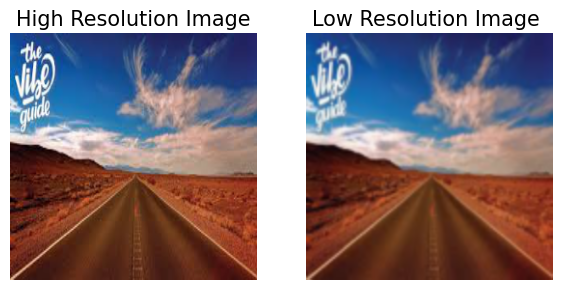

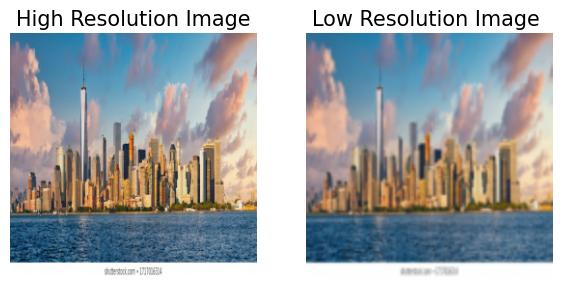

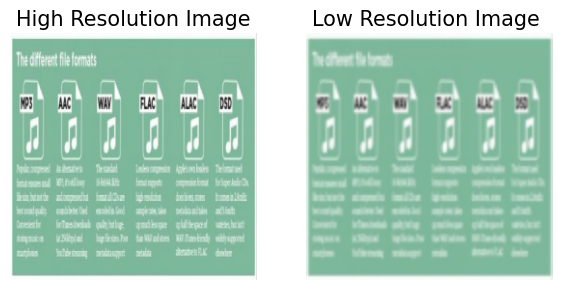

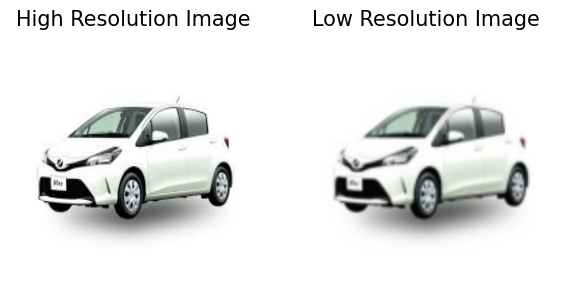

In [52]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', fontsize = 15)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Low Resolution Image ', fontsize = 15)
    plt.imshow(low_img[a])
    plt.axis('off')

In [17]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [54]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [55]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_10 (Sequential)     (None, 128, 128, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_11 (Sequential)     (None, 64, 64, 128)  147584      ['sequential_10[0][0]']          
                                                                                            

In [56]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [57]:
model.fit(train_low_image, train_high_image, epochs = 5, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/5
700/700 [==============================] - 18s 25ms/step - loss: 0.0445 - acc: 0.6769 - val_loss: 0.0308 - val_acc: 0.6936
Epoch 2/5
700/700 [==============================] - 16s 23ms/step - loss: 0.0274 - acc: 0.7707 - val_loss: 0.0229 - val_acc: 0.8656
Epoch 3/5
700/700 [==============================] - 18s 25ms/step - loss: 0.0234 - acc: 0.7993 - val_loss: 0.0209 - val_acc: 0.8262
Epoch 4/5
700/700 [==============================] - 17s 25ms/step - loss: 0.0214 - acc: 0.8101 - val_loss: 0.0206 - val_acc: 0.7821
Epoch 5/5
700/700 [==============================] - 19s 27ms/step - loss: 0.0208 - acc: 0.8098 - val_loss: 0.0250 - val_acc: 0.6695


In [58]:
model.save("final_model.h5")

1/1 [==============================] - 0s 120ms/step


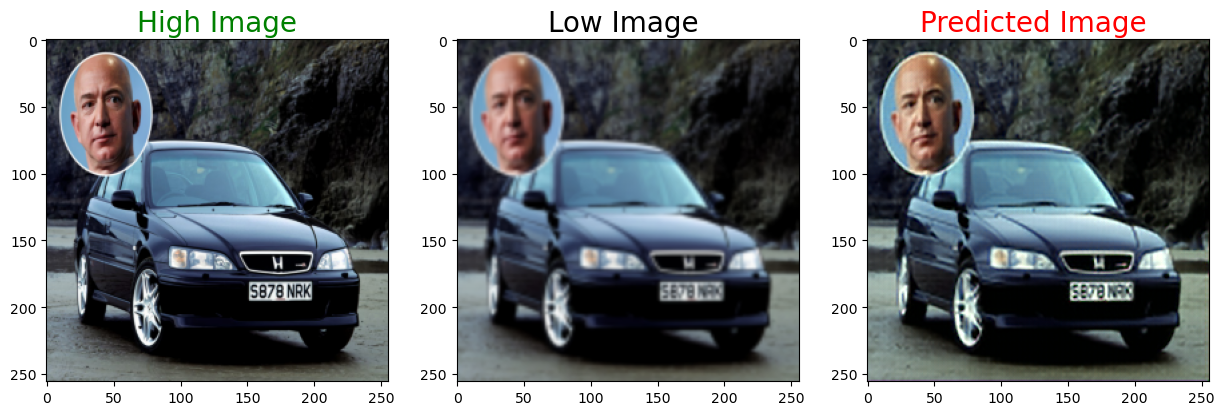

1/1 [==============================] - 0s 15ms/step


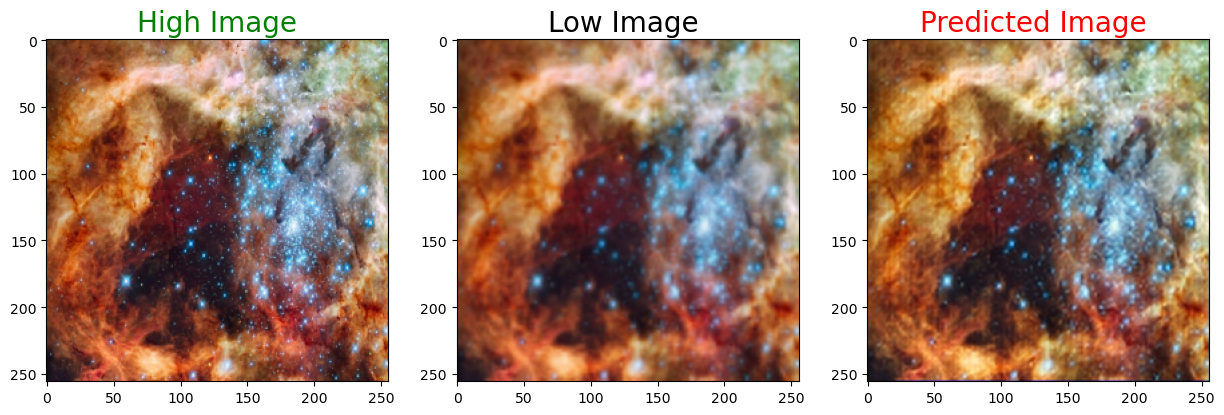

1/1 [==============================] - 0s 15ms/step


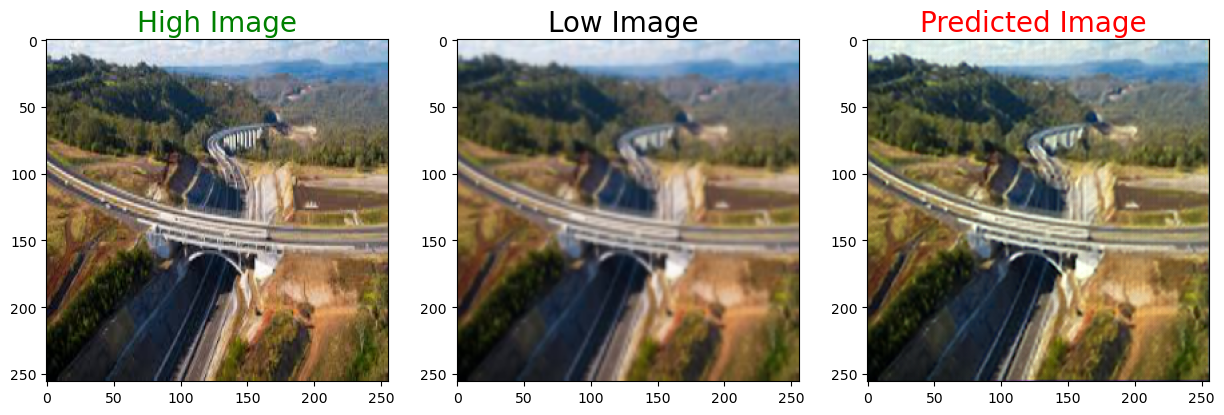

1/1 [==============================] - 0s 15ms/step


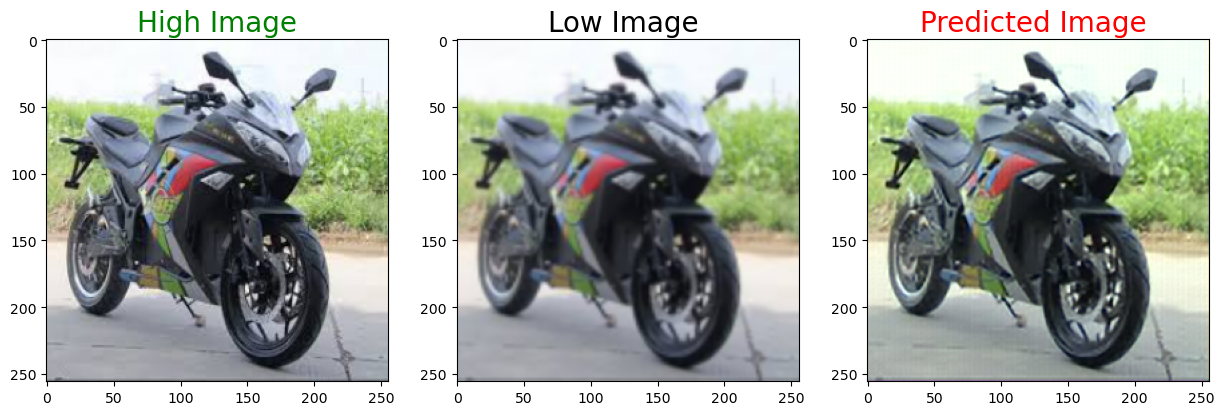

1/1 [==============================] - 0s 26ms/step


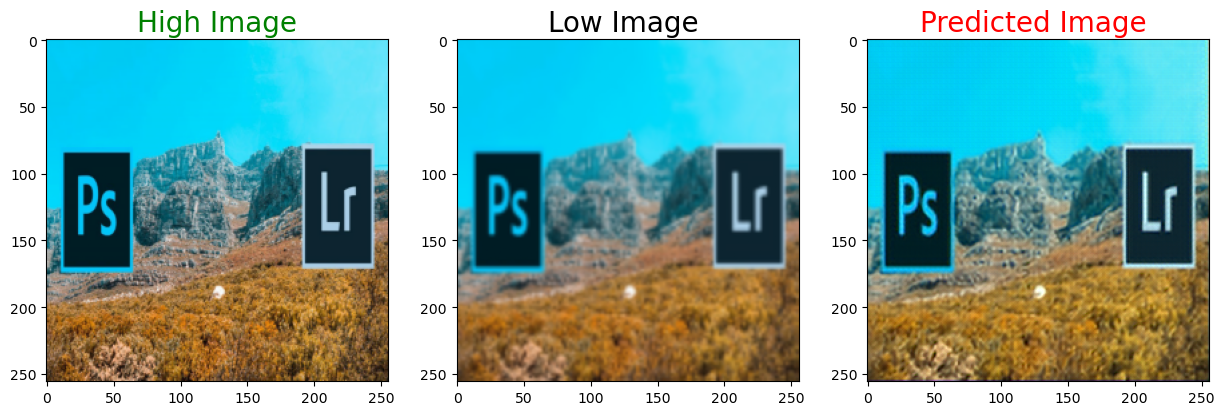

1/1 [==============================] - 0s 18ms/step


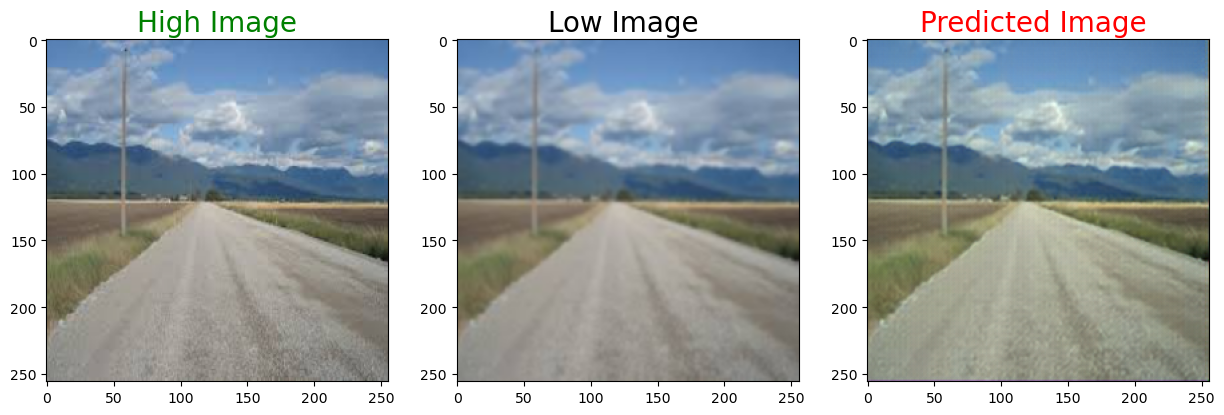

1/1 [==============================] - 0s 16ms/step


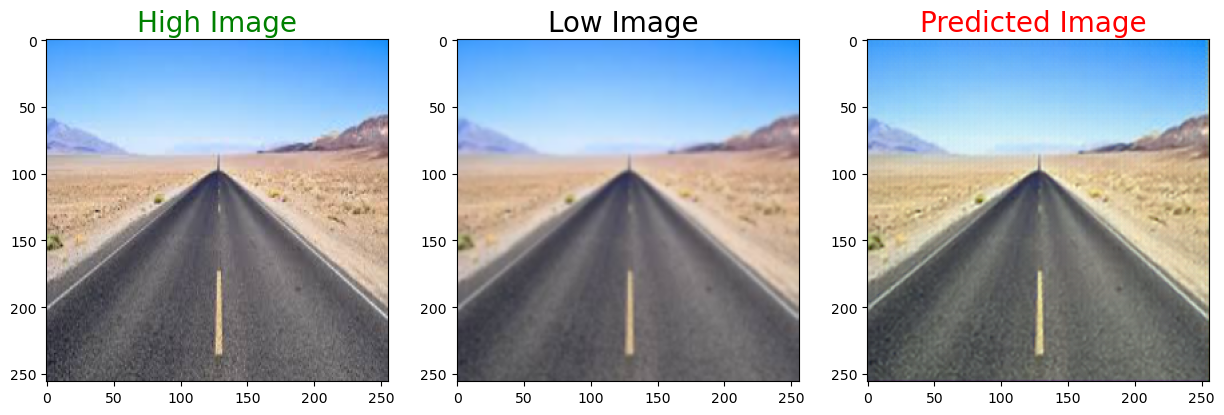

1/1 [==============================] - 0s 15ms/step


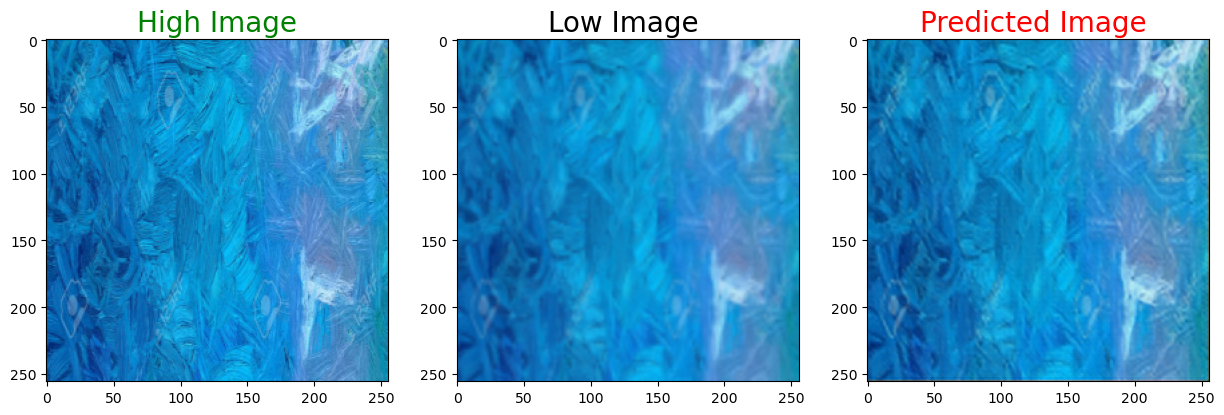

1/1 [==============================] - 0s 20ms/step


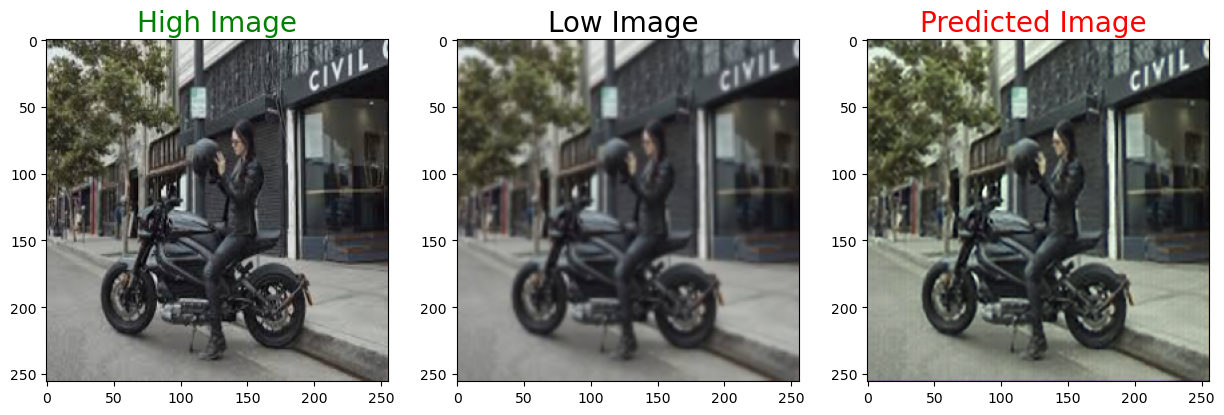

In [18]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    file_name = 'predicted_{}.jpg'.format(i)
    cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [3]:
model = load_model(r'final_model.h5')

In [39]:
def single_predict(path, save=False):
    def plot_for_single(low,predicted):
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.title('Low Image ', color = 'black', fontsize = 20)
        plt.imshow(low)
        plt.subplot(1,2,2)
        plt.title('Predicted', color = 'green', fontsize = 20)
        plt.imshow(predicted)

        plt.show()

    SIZE = 256
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0

    predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    plot_for_single(img, predicted)
    
    if save:
        file_name = 'predicted.jpg'
        cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 20ms/step


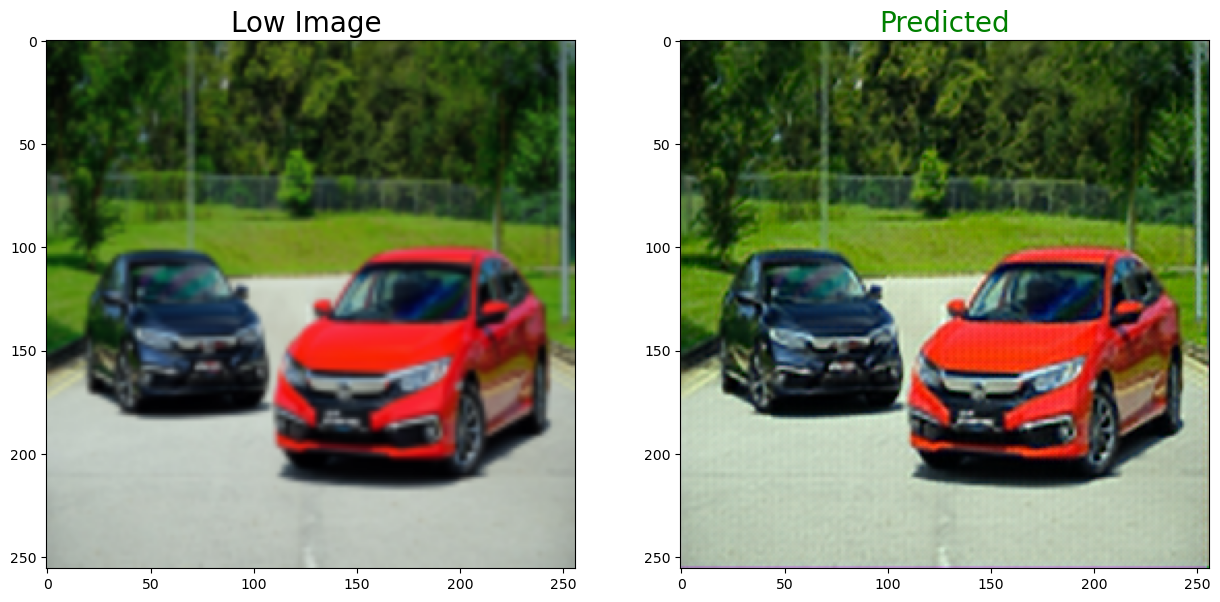

In [40]:
single_predict('0.png', 1)